In [22]:
# This file serves to compare real school data to simulated data
# INPUT:
#     g matrix of connections between individuals
#     X matrix of characteristics of the individuals
# OUTPUT:
#     segregation plots
#     outdegree plot
#     outdegree correlations plot
#     local clustering coefficient plot

In [ ]:
# check for 2 school communities
# reciprocation measures
# divide plots into 2 parts

In [1]:
import pickle
import numpy as np
import copy
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Import the data from pickle files
g_list = pickle.load(open("g_list.pkl", "rb"))
X_list = pickle.load(open("X_list.pkl", "rb"))
g_simulations = pickle.load(open("simulated_friendships.pkl", "rb"))

In [8]:
# make a list of schools trained on, smaller schools not trained on and the simulations
# this results in the list datasets, which contains all information to be analysed
# the format of each separate dataset is a list: [g matrix, X matrix]
n_0_99 = [1,60,67,68,73,74]
n_100_399 = [0,2,3,4,6,7,16,19,52,69]
n_0_399 = n_0_99 + n_100_399
n_0_399.sort()
schools_0_99 = []
for n in n_0_99:
    schools_0_99.append([g_list[n],X_list[n]])
schools_100_399 = []
for n in n_100_399:
    schools_100_399.append([g_list[n],X_list[n]])
simulations = []
for pos,n in enumerate(n_0_399):
    simulations.append([g_simulations[pos],X_list[n]])
datasets = [schools_0_99,schools_100_399,simulations]

In [19]:
# functions to determine network characteristics

def determine_outdegree(connectivity):
    # this returns the outdegree 
    # and correlation of the outdegree of neighbours

    # total number of connections
    mean_connections = np.sum(connectivity)/len(connectivity)
    # mean corrected connectivity vector
    connectivity_vector = np.zeros(len(connectivity))
    mc_connectivity_vector = np.zeros(len(connectivity))
    for n_student, connections in enumerate(connectivity):
        connectivity_vector[n_student] = np.sum(connections)
        mc_connectivity_vector[n_student] = np.sum(connections)-mean_connections   
    # outdegree correlation matrix for all nodes (so even unconnected)
    outdeg_corr = np.dot(np.transpose([mc_connectivity_vector]),[mc_connectivity_vector])
    # outdegree correlation matrix for neighbours
    neigh_outdeg_corr = outdeg_corr * connectivity
    # mean and standard deviation of the outdegree correlation of neighbours
    mean_outdeg = np.mean(connectivity_vector)
    std_outdeg = np.std(connectivity_vector)
    mean_outdeg_corr = np.mean(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    std_outdeg_corr = np.std(neigh_outdeg_corr[np.nonzero(neigh_outdeg_corr)])
    
    return mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr

def analyse_network(connectivity, characteristics):
    # OUTPUT:
    # average degree of nodes network            > av_degree
    # density at maximum reach (RCHDEN)          > den_max_reach
    # relative density (RELDEN)                  > rel_den
    # proportion symmetric dyads (PTCMUT)        > p_symm_dyads
    # mutuality index (RHO2)                     > mutuality_index
    # amount of clustering (groups of friends)   > clustering_coefficient  [mean, std dev]
    # homophily index per trait in dict          > homoph_ind              {"0_", "1_", "2_"}
    # segregation index per trait                > segreg_ind              [sex, race, grade]
    
    # INPUT: 
    # - connectivity matrix with row-students nominating column-students as friends
    # - characteristics matrix with row per student, with integers indicating every group for each characteristic (sex, race, grade)
    
    nodes = connectivity.shape[0]
    mutual_d = 0
    asym_d = 0
    #     trait = ["sex", "race", "grade", "school", "_", "_"]
    
    
    #density DENX2
    #DENX2 = np.sum(connectivity)/(nodes*(nodes-1))
    
    
    # density at maximum reach RCHDEN
    
    # define the function to tranfer adjacency matrix to reachability matrix  
    # Prints reachability matrix of graph[][] using Floyd Warshall algorithm 
    # function found on https://www.geeksforgeeks.org/transitive-closure-of-a-graph/
    reachability = copy.deepcopy(connectivity)
    '''reach[][] will be the output matrix that will finally 
    have reachability values. 
    Initialize the solution matrix same as input graph matrix'''
    reach =[i[:] for i in reachability] 
    '''Add all vertices one by one to the set of intermediate 
    vertices. 
    ---> Before start of a iteration, we have reachability value 
    for all pairs of vertices such that the reachability values 
    consider only the vertices in set  
    {0, 1, 2, .. k-1} as intermediate vertices. 
    ----> After the end of an iteration, vertex no. k is 
    added to the set of intermediate vertices and the  
    set becomes {0, 1, 2, .. k}'''
    for k in range(nodes): 
              
        # Pick all vertices as source one by one 
        for i in range(nodes): 
                  
            # Pick all vertices as destination for the 
            # above picked source 
            for j in range(nodes): 
                      
                # If vertex k is on a path from i to j,  
                    # then make sure that the value of reach[i][j] is 1 
                reach[i][j] = reach[i][j] or (reach[i][k] and reach[k][j]) 
    
    RCHDEN = np.sum(reach)/(nodes*(nodes-1))
    
    
    # relative density RELDEN
    RELDEN = np.sum(connectivity)/(10*nodes)


    # create upper triangular matrix with 2's on mutual dyads, 1's on asymmetric dyads and count occurrence
    added_up = np.triu(connectivity + np.transpose(connectivity))
    mutual_d = np.count_nonzero(added_up == 2)
    asym_d = np.count_nonzero(added_up == 1)
    total_d = mutual_d + asym_d
    
    # calculate proportion symmetric dyads (PTCMUT) and asymmetric dyads (PTCASY)
    PTCMUT = mutual_d / total_d
    #PTCASY = asym_d / total_d
    
    
    # count total out_degree connections
    out_degree = connectivity.sum()
    # average out_degree
    av_degree = out_degree / nodes
    # take the sum of squares of the out degree connections per individual (row)
    sum_squares_out = (connectivity.sum(axis=1)**2).sum()
    
    # calculate mutuality index (RHO2) (according to Katz and Powell’s (1955))
    RHO2 = (2*(nodes - 1)**2 * mutual_d - out_degree**2 + sum_squares_out) / (out_degree*(nodes - 1)**2 - out_degree**2 + sum_squares_out)
    
    # determine the local clustering coefficient mean and standard deviation
    clustering_coefficients = []
    for n_node, connections in enumerate(connectivity):
        # the amount of neighbours each node has
        n_neighbours = np.sum(connectivity[n_node])
        # only consider nodes with at least 2 neighbours
        if n_neighbours >= 2:
            # matrix of the nodes that are both neighbours of the node considered
            neighbour_matrix = np.dot(np.transpose([connectivity[n_node]]),[connectivity[n_node]])
            # the amount of connections between neighbours
            neighbour_connections = np.sum(connectivity*neighbour_matrix)
            # the amount of connections between neighbours divided by the possible amount of connections
            clustering_coefficients.append(neighbour_connections / (n_neighbours*(n_neighbours-1)))
    mean_clustering_coefficient = np.mean(clustering_coefficients)
    std_clustering_coefficient = np.std(clustering_coefficients)
    clustering_coefficient = [mean_clustering_coefficient,std_clustering_coefficient]
    
    
    # create homophily index dictionary and lists for the segregation index
    homoph_ind = dict()
    segreg_ind = []
    
    # iterate through different characteristics (sex, race, grade)
    for i in range(characteristics.shape[1]):
        # get different groups of this characteristic in dataset
        # characs = sorted(list(set(characteristics[:,i])))
        characs = sorted(list(set(characteristics.ix[:,i])))
        amount = len(characs)
        
        # counters for individuals per characteristic group and out-group nominations
        charac_count = []
        charac_out = []
        
        # counters for expected and observed cross trait nominations
        exp_cross = 0        
        obs_cross = 0
        
        # iterate through different groups of this characteristic
        for j in range(amount):
            # indicate indices of members this group and save size group
            #indices = np.where(characteristics[:,i] == characs[j])[0]
            indices = np.where(characteristics.ix[:,i] == characs[j])[0]
            charac_count.append(len(indices))
            
            # create a submatrix of all nominations from this group and save amount
            submat_trait = connectivity[np.ix_(indices,)]
            charac_out.append(submat_trait.sum())
            
            # create 2 submatrices outgoing connections: 1 to individuals same group and 1 to individuals different group
            submat_same = connectivity[np.ix_(indices,indices)]
            mask = np.ones(connectivity.shape[0], np.bool)
            mask[indices] = 0
            submat_diff = submat_trait[:,mask]
            
            # count amount outgoing connections to same and to different group
            out_same = np.mean(submat_same.sum(axis=1))
            out_diff = np.mean(submat_diff.sum(axis=1))
            
            # add amount of cross trait nominations of this group to total
            obs_cross += submat_diff.sum()
            
            # calculate and save homophily index from this group for this characteristic
            homoph_ind[str(i) + "_" + str(characs[j])] = out_same / (out_same + out_diff)
        
        # calculate expected cross trait nominations (added for all combinations of traits (except with self))
        for row in range(amount):
            for col in range(amount):
                if row == col: pass
                else:
                    exp_cross += charac_out[row] * ((charac_count[row] * charac_count[col]) / (charac_count[row] * (nodes - 1)))
        
        # calculate and save segregation index for this trait
        if exp_cross == 0:
            segreg_ind.append(999)
            if amount == 1:
                warnings.warn("Just one group: no segregation index for this trait possible.")
            else:
                warnings.warn("Expected cross trait nominations is zero: no segregation index for this trait possible.")
        else:
            segreg_ind.append((exp_cross - obs_cross) / exp_cross)
    
    segreg_ind
    
    return av_degree, RCHDEN, RELDEN, PTCMUT, RHO2, clustering_coefficient, homoph_ind, segreg_ind
    

In [30]:
# perform the analyses to all datasets
# output: 
# list of datasets
# list of schools
# list of [school_characteristics, characteristics_matrix]

validation_results = []
for dataset in datasets:
    dataset_netw_vals = []
    for num, school in enumerate(dataset):
        print("analysing school number {}".format(num))
        # store the network characteristics for all schools
        # store the single number variables in a matrix
        number_of_students = len(school[0])
                # OUTPUT analyse_network:    
                # average degree of nodes network            > av_degree
                # density at maximum reach (RCHDEN)          > den_max_reach
                # relative density (RELDEN)                  > rel_den
                # proportion symmetric dyads (PTCMUT)        > p_symm_dyads
                # mutuality index (RHO2)                     > mutuality_index
                # amount of clustering (groups of friends)   > clustering_coefficient  [mean, std dev]
                # homophily index per trait in dict          > homoph_ind              {"0_", "1_", "2_"}
                # segregation index per trait                > segreg_ind              [sex, race, grade]
        average_degree, density_max_reach, relative_density, proportion_symmetric_dyads,mutuality_index,clustering_coefficient,homophily_index,segregation_index= analyse_network(school[0],school[1])
        mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr = determine_outdegree(school[0])
        school_characteristics = [number_of_students,average_degree, density_max_reach, relative_density, proportion_symmetric_dyads,mutuality_index,clustering_coefficient[0],clustering_coefficient[1],mean_outdeg,std_outdeg,mean_outdeg_corr,std_outdeg_corr]
        segregation_values = [homophily_index,segregation_index]
        characteristics_matrix = np.array(school_characteristics)
        print("characteristics_matrix=",characteristics_matrix)
        print("segregation_index=",segregation_index)
        school_values = [characteristics_matrix,segregation_values]
        dataset_netw_vals.append(school_values)
    validation_results.append(dataset_netw_vals)

analysing school number 0
characteristics_matrix= [30.          4.          0.77586207  0.4         0.39534884  0.49885405
  0.37473545  0.23610078  4.          2.96647939  2.90654206  8.71836895]
segregation_index= [0.09887005649717526, -0.07617187500000001, 0.29102478231748174, 999]
analysing school number 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:136: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: UserWarning: Just one group: no segregation index for this trait possible.


characteristics_matrix= [98.          3.40816327  0.54386703  0.34081633  0.24163569  0.36715645
  0.23419974  0.16621944  3.40816327  2.93757061  2.94907312 10.90333927]
segregation_index= [0.20501529051987763, 0.17248167997375044, 0.6553078476845964, 999]
analysing school number 2
characteristics_matrix= [76.          5.78947368  0.84859649  0.57894737  0.27906977  0.38937005
  0.35812358  0.20450992  5.78947368  2.75927045  1.22350793  6.66634012]
segregation_index= [0.0764656415185007, 0.06605787476280832, 0.6069725972560865, 999]
analysing school number 3
characteristics_matrix= [74.          6.2972973   0.95945946  0.62972973  0.30167598  0.41300022
  0.40015091  0.19809341  6.2972973   2.59797078  0.37663531  5.76591067]
segregation_index= [0.19247787610619466, -0.122909199522103, 0.6565308988764044, 999]
analysing school number 4
characteristics_matrix= [41.          5.19512195  0.81768293  0.5195122   0.3566879   0.4555843
  0.3017306   0.12870966  5.19512195  2.67982082 -0.17

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in double_scalars


characteristics_matrix= [107.           4.           0.58975489   0.4          0.20903955
   0.32027852   0.30674603   0.28432805   4.           2.97654382
   3.43131868   9.7229878 ]
segregation_index= [0.1620736341005372, 0.16237833670617707, 0.46509907529722566, 999]
analysing school number 4
characteristics_matrix= [196.           4.70918367   0.82422815   0.47091837   0.24898512
   0.38384874   0.25396825   0.20707686   4.70918367   2.88771454
   2.47441317   7.85072102]
segregation_index= [0.010524337530539395, 0.23546694442260835, 0.454940023035649, 999]
analysing school number 5
characteristics_matrix= [2.49000000e+02 4.87951807e+00 8.11423112e-01 4.87951807e-01
 2.61682243e-01 4.03087453e-01 2.84119461e-01 2.04805979e-01
 4.87951807e+00 2.93872192e+00 2.45507319e+00 9.30002887e+00]
segregation_index= [0.15403684826368907, 0.47486809219661213, 0.5231437899333026, 999]
analysing school number 6
characteristics_matrix= [2.83000000e+02 5.11307420e+00 8.42944140e-01 5.11307420e-01


In [31]:
# save the validation_results
pickle.dump(validation_results, open("validation_results.pkl", "wb"))

In [2]:
# skippable unless the analysis was performed earlier 
# open the validation results
validation_results = pickle.load(open("validation_results.pkl", "rb"))

In [3]:
# extract the school size, outdegree, outdegree correlation, clustering coefficient and segregation from the data
n_students_ordered = []
degree_ordered = []
degree_std_ordered = []
correlation_ordered = []
correlation_std_ordered = []
clustering_ordered = []
clustering_std_ordered = []
segregation_ordered = []
for n_set,dataset in enumerate(validation_results):
    n_students_s = []
    degree_s = []
    degree_std_s = []
    correlation_s = []
    correlation_std_s = []
    clustering_s = []
    clustering_std_s = []
    segregation_s = []
    for n_school,school in enumerate(dataset):
        n_students_s.append(validation_results[n_set][n_school][0][0])
        degree_s.append(validation_results[n_set][n_school][0][-4])
        degree_std_s.append(validation_results[n_set][n_school][0][-3])
        correlation_s.append(validation_results[n_set][n_school][0][-2])
        correlation_std_s.append(validation_results[n_set][n_school][0][-1])
        clustering_s.append(validation_results[n_set][n_school][0][-6])
        clustering_std_s.append(validation_results[n_set][n_school][0][-5])
        segregation_s.append(validation_results[n_set][n_school][1][1])
    n_students_ordered.append(n_students_s)
    degree_ordered.append(degree_s)
    degree_std_ordered.append(degree_std_s)
    correlation_ordered.append(correlation_s)
    correlation_std_ordered.append(correlation_std_s)
    clustering_ordered.append(clustering_s)
    clustering_std_ordered.append(clustering_std_s)
    segregation_ordered.append(np.array(segregation_s))
n_students = np.array(n_students_ordered)
degree = np.array(degree_ordered)
degree_std = np.array(degree_std_ordered)
correlation = np.array(correlation_ordered)
correlation_std = np.array(correlation_std_ordered)
clustering = np.array(clustering_ordered)
clustering_std = np.array(clustering_std_ordered)

In [4]:
# for the number of students add .5 to the simulated data to make plot readable
n_students[2] = n_students[2]+np.ones(len(n_students[2]))/2

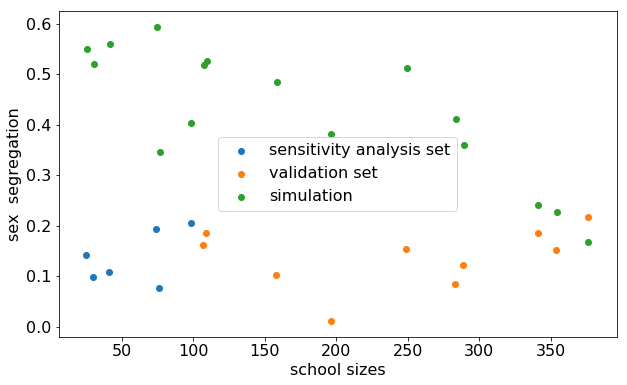

Segregation of sexes (see formula {}). The sensitivity set are the six schools with less than 100 students used for ...


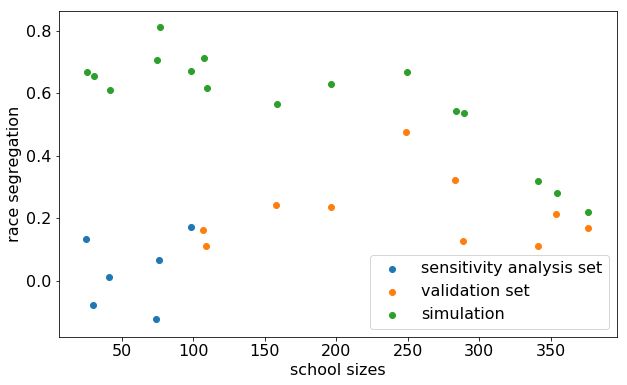

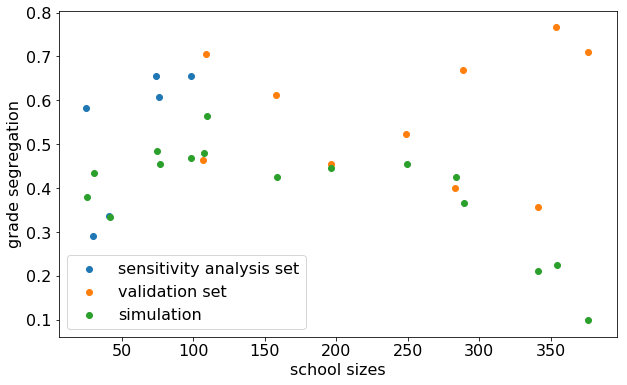

In [15]:
# make segregation plots
# increase the font size
plt.rcParams.update({'font.size': 16})

# plot the sex segregation
fig= plt.figure(figsize=(10,6))
plt.scatter(n_students[0],list(segregation_ordered[0][:,0]),label="tuning dataset")
plt.scatter(n_students[1],list(segregation_ordered[1][:,0]),label="validation set")
plt.scatter(n_students[2],list(segregation_ordered[2][:,0]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("sex  segregation")
plt.legend()
plt.show()
print("Segregation of sexes (see formula {}). The sensitivity set are the six schools with less than 100 students used for ...")

# plot the race segregation
fig= plt.figure(figsize=(10,6))
plt.scatter(n_students[0],list(segregation_ordered[0][:,1]),label="tuning dataset")
plt.scatter(n_students[1],list(segregation_ordered[1][:,1]),label="validation set")
plt.scatter(n_students[2],list(segregation_ordered[2][:,1]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("race segregation")
plt.legend()
plt.show()

# plot the grade segregation
fig= plt.figure(figsize=(10,6))
plt.scatter(n_students[0],list(segregation_ordered[0][:,2]),label="tuning dataset")
plt.scatter(n_students[1],list(segregation_ordered[1][:,2]),label="validation set")
plt.scatter(n_students[2],list(segregation_ordered[2][:,2]),label="simulation")
plt.xlabel("school sizes")
plt.ylabel("grade segregation")
plt.legend()
plt.show()

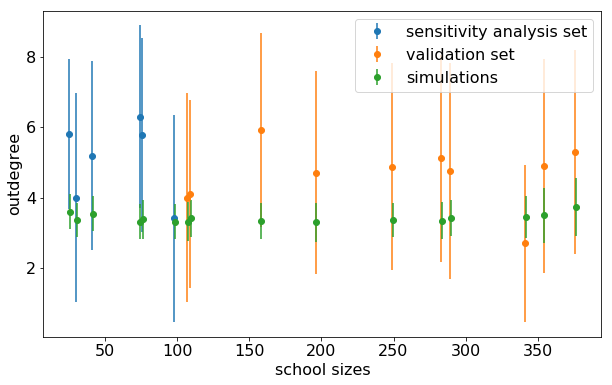

Mean and standard deviation of the outdegree. Social networks show a bounded degree distribution, the degree distribution is more bounded in the simulation in comparison to the data


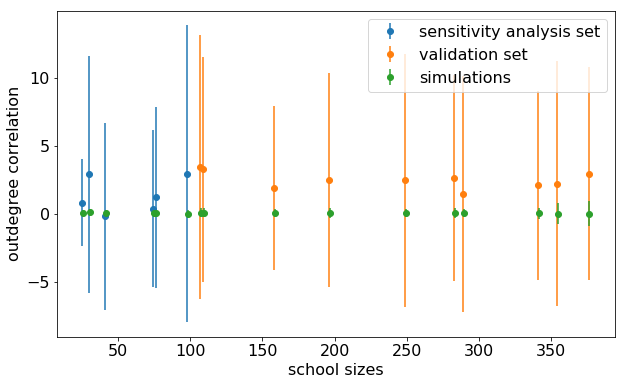

Mean and standard deviation of the outdegree correlation. Social networks show positive degree assortativity: students with more connections preferentially attach to other highly attached students. The simulated outdegree correlation is lower but has especially much less variation compared to the school data.


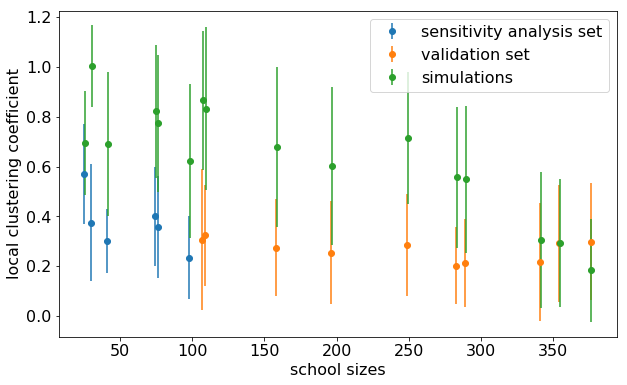

Mean and standard deviation of the local clustering coefficient. Social networks show non-trivial clustering / locally dense clusters / triadic closure: direct neighbours are likely to also directly conect to eachother. The local clustering seems too high in our model compared to school data


In [23]:
# make network characteristics plots
# plot the size of the school vs the outdegree
fig= plt.figure(figsize=(10,6))
plt.errorbar(n_students[0],degree[0],yerr=degree_std[0],fmt="o",label="sensitivity analysis set")
plt.errorbar(n_students[1],degree[1],yerr=degree_std[1],fmt="o",label="validation set")
plt.errorbar(n_students[2],degree[2],yerr=degree_std[2],fmt="o",label="simulations")
plt.xlabel("school sizes")
plt.ylabel("outdegree")
plt.legend()
plt.show()
print("Mean student and between student standard deviation of the outdegree. Social networks show a bounded degree distribution, the degree distribution is more bounded in the simulation in comparison to the data")

# plot the size of the school vs the outdegree correlation
fig= plt.figure(figsize=(10,6))
plt.errorbar(n_students[0],correlation[0],yerr=correlation_std[0],fmt="o",label="sensitivity analysis set")
plt.errorbar(n_students[1],correlation[1],yerr=correlation_std[1],fmt="o",label="validation set")
plt.errorbar(n_students[2],correlation[2],yerr=correlation_std[2],fmt="o",label="simulations")
plt.xlabel("school sizes")
plt.ylabel("outdegree correlation")
plt.legend()
plt.show()
print("Mean and standard deviation of the outdegree correlation. Social networks show positive degree assortativity: students with more connections preferentially attach to other highly attached students. The simulated outdegree correlation is lower but has especially much less variation compared to the school data.")

# plot the size of the school vs the clustering coefficient
fig= plt.figure(figsize=(10,6))
plt.errorbar(n_students[0],clustering[0],yerr=clustering_std[0],fmt="o",label="sensitivity analysis set")
plt.errorbar(n_students[1],clustering[1],yerr=clustering_std[1],fmt="o",label="validation set")
plt.errorbar(n_students[2],clustering[2],yerr=clustering_std[2],fmt="o",label="simulations")
plt.xlabel("school sizes")
plt.ylabel("local clustering coefficient")
plt.legend()
plt.show()
print("Mean and standard deviation of the local clustering coefficient. Social networks show non-trivial clustering / locally dense clusters / triadic closure: direct neighbours are likely to also directly conect to eachother. The local clustering seems too high in our model compared to school data")